In [1]:
from google.colab import files
uploaded = files.upload()

Saving task1_cleaned.zip to task1_cleaned.zip


In [15]:
import pandas as pd
import zipfile

zip_file = "task1_cleaned.zip"

with zipfile.ZipFile(zip_file) as z:
    with z.open("task1_cleaned.csv") as f:
        df = pd.read_csv(f)

df.head()

/tmp/ipython-input-3661416305.py:8: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,LossRatio
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,NaN
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,NaN


In [26]:
# -----------------------------
# Required Libraries
# -----------------------------
import pandas as pd
import numpy as np

# Preprocessing & pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Feature importance
import shap


In [16]:
# See all column names
df.columns.tolist()


['UnderwrittenCoverID',
 'PolicyID',
 'TransactionMonth',
 'IsVATRegistered',
 'Citizenship',
 'LegalType',
 'Title',
 'Language',
 'Bank',
 'AccountType',
 'MaritalStatus',
 'Gender',
 'Country',
 'Province',
 'PostalCode',
 'MainCrestaZone',
 'SubCrestaZone',
 'ItemType',
 'mmcode',
 'VehicleType',
 'RegistrationYear',
 'make',
 'Model',
 'Cylinders',
 'cubiccapacity',
 'kilowatts',
 'bodytype',
 'NumberOfDoors',
 'VehicleIntroDate',
 'CustomValueEstimate',
 'AlarmImmobiliser',
 'TrackingDevice',
 'CapitalOutstanding',
 'NewVehicle',
 'WrittenOff',
 'Rebuilt',
 'Converted',
 'CrossBorder',
 'NumberOfVehiclesInFleet',
 'SumInsured',
 'TermFrequency',
 'CalculatedPremiumPerTerm',
 'ExcessSelected',
 'CoverCategory',
 'CoverType',
 'CoverGroup',
 'Section',
 'Product',
 'StatutoryClass',
 'StatutoryRiskType',
 'TotalPremium',
 'TotalClaims',
 'LossRatio']

In [18]:
df.columns = df.columns.str.strip().str.lower()


In [19]:
num_features = ['cylinders', 'cubiccapacity', 'kilowatts', 'customvalueestimate']
print([col for col in num_features if col not in df.columns])


[]


In [20]:
imputer = SimpleImputer(strategy='median')
df[num_features] = imputer.fit_transform(df[num_features])


In [22]:
# Categorical columns – pick main features
cat_features = ['gender', 'province', 'make', 'model', 'vehicletype', 'bodytype']
cat_features = [col for col in cat_features if col in df.columns]  # ✅ added closing ]


In [23]:
num_features = [col for col in num_features if col in df.columns]
cat_features = [col for col in cat_features if col in df.columns]

In [24]:
df_model = df[df['totalclaims'] > 0].copy()
y = df_model['totalclaims']
X = df_model[num_features + cat_features]


In [27]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

In [28]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # updated for sklearn 1.2+
])


In [29]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['cylinders', 'cubiccapacity',
                                                   'kilowatts',
                                                   'customvalueestimate']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'province', 'make',
                                                   'model', 'vehicletype',
                                                   'bodytype'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, n_estimators=200,
                                       random_state=42))])

In [32]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

RMSE: 40989.38
R2 Score: -0.04


 97%|=================== | 2165/2230 [00:18<00:00]       

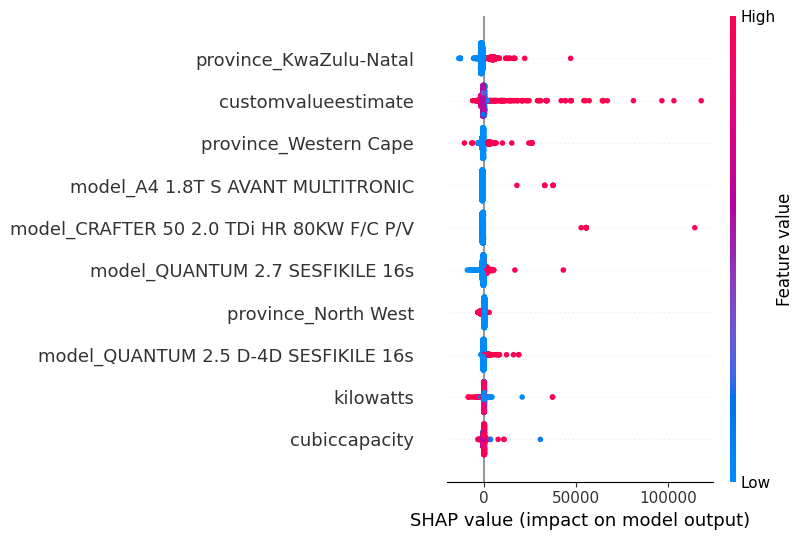

In [33]:
X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
feature_names = (
    num_features +
    list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features))
)

explainer = shap.Explainer(model.named_steps['regressor'], X_train_transformed)
shap_values = explainer(X_train_transformed)

# Plot top 10 features
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, max_display=10)